# Using the MNIST256 data set

In [8]:
import torch
import torchvision

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from PIL import Image
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from utils import test, plain_gradient, input_x_gradient, integrated_gradients, project_into_tangent_space

In [2]:
device = "cuda"

## Load the data 
##### The MNIST256 dataset is provided in image folder format

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Grayscale()])

trainset = ImageFolder('../datasets/mnist256/train', transform = transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)

valset = ImageFolder('../datasets/mnist256/val', transform = transform)
valloader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=8)

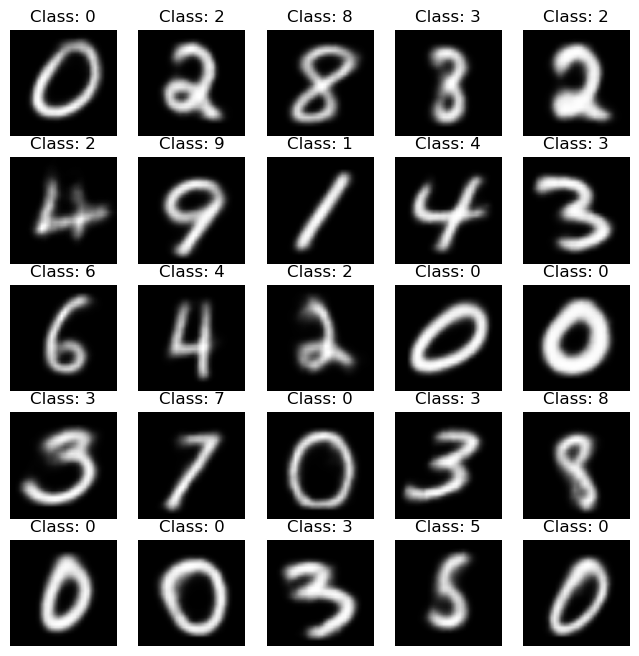

In [5]:
# visualize examples from the training data
fix, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        img, c = iter(trainloader).__next__()
        axs[i,j].imshow(img[0, 0, :, :], cmap='gray', interpolation='none')
        axs[i,j].set_title(f'Class: {c[0]}')
        axs[i,j].axis('off')
plt.show()

## Train a model

In [6]:
model = torchvision.models.resnet18()
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # a single input channel
model.fc = torch.nn.Linear(512, 10) # 10-class problem
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
ce_loss = torch.nn.CrossEntropyLoss()

In [9]:
for i_epoch in range(5):    
    model.train()
    train_loss, train_zero_one_loss = 0, 0
    for img, label in tqdm(trainloader):
        img, label = img.to(device), label.to(device)
        pred = model(img)
        optimizer.zero_grad()
        loss = ce_loss(pred, label)
        loss.backward()
        train_loss += loss.item()  
        train_zero_one_loss += (pred.softmax(dim=1).argmax(dim=1) != label).sum().item()
        optimizer.step()
    print(f'Epoch {i_epoch}: Train Loss: {train_loss / len(trainloader.dataset)}  Train Error: {train_zero_one_loss / len(trainloader.dataset)}')
    test(model, valloader, device)

100%|██████████| 469/469 [02:09<00:00,  3.61it/s]

Epoch 0: Train Loss: 0.0007175109995994716  Train Error: 0.029316666666666668


Test Error:  0.031625


100%|██████████| 469/469 [02:12<00:00,  3.54it/s]

Epoch 1: Train Loss: 0.00042565231246408076  Train Error: 0.018516666666666667


Test Error:  0.020125


100%|██████████| 469/469 [02:13<00:00,  3.52it/s]

Epoch 2: Train Loss: 0.0003412798237288371  Train Error: 0.014933333333333333


Test Error:  0.02325


100%|██████████| 469/469 [02:13<00:00,  3.52it/s]

Epoch 3: Train Loss: 0.00029318112477776597  Train Error: 0.013283333333333333


Test Error:  0.022875


100%|██████████| 469/469 [02:13<00:00,  3.52it/s]

Epoch 4: Train Loss: 0.00028216548770239265  Train Error: 0.0128


Test Error:  0.018625


## The dataset contains the tangent spaces of the validation images

In [10]:
def load_minst256_tanget(root, val_img_idx):
    """Load the tangent space of a single image from the MNIST256 validaiton set."""
    tsp = np.zeros((8, 256, 256))
    for dim in range(8):
        fname = f'{root}/tangent/{val_img_idx}/dim{dim}.png'
        img = Image.open(fname)
        tsp[dim, :, :] = np.array(img) / 127.5 - 1 
    return tsp

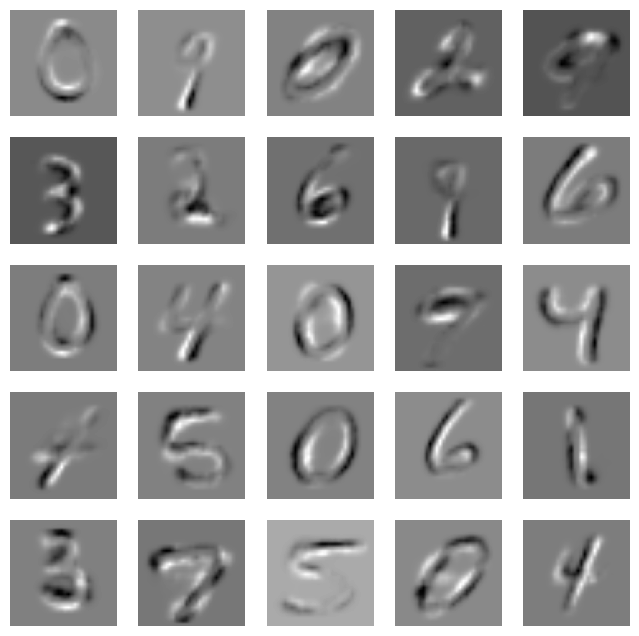

In [12]:
# visualize directions in the tangent space
fix, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        idx = np.random.randint(8000)
        axs[i,j].imshow(load_minst256_tanget('../datasets/mnist256', idx)[0].reshape(256, 256), cmap='gray', interpolation='none')
        axs[i,j].axis('off')

## Compute feature attributions

In [20]:
valloader = DataLoader(valset, batch_size=1, shuffle=False, num_workers=8) # load one image at a time and don't shuffle

grad_list, igx_list, int_grad_list = [], [], []
model.eval()
for idx, (img, label) in tqdm(enumerate(valloader)):
    img, label = img.to(device), label.to(device)
    grad = plain_gradient(model, img, target=label, device=device)
    grad_list.append(grad)
    ixg = input_x_gradient(model, img, target=label, device=device)
    igx_list.append(ixg)
    int_grad = integrated_gradients(model, img, target=label, device=device)
    int_grad_list.append(int_grad)

8000it [12:33, 10.61it/s]


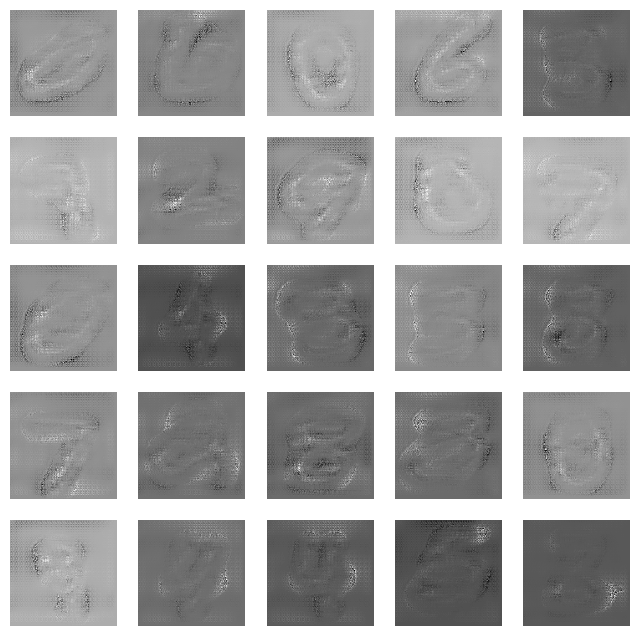

In [21]:
# visualize the attributions
fix, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        idx = np.random.randint(0, 8000)
        attr = int_grad_list[idx]
        axs[i,j].imshow(attr, cmap='gray', interpolation='none')
        axs[i,j].axis('off')
plt.show()

## The alignment of attributions with the tangent space

In [22]:
frac_grad_its = []
frac_ixg_its = []
frac_int_grad_its = []
for idx in tqdm(range(8000)):
    # load the tanget space of the validation image
    tanget_space = load_minst256_tanget('../datasets/mnist256', idx)

    # compute projections into tangent space, and fraction in tangent space
    projection = project_into_tangent_space(tanget_space, grad_list[idx])
    frac_grad_its.append(np.linalg.norm(projection.flatten()) / np.linalg.norm(grad_list[idx].flatten()))
    projection = project_into_tangent_space(tanget_space, igx_list[idx])
    frac_ixg_its.append(np.linalg.norm(projection.flatten()) / np.linalg.norm(igx_list[idx].flatten()))
    projection = project_into_tangent_space(tanget_space, int_grad_list[idx])
    frac_int_grad_its.append(np.linalg.norm(projection.flatten()) / np.linalg.norm(int_grad_list[idx].flatten()))

100%|██████████| 8000/8000 [02:12<00:00, 60.23it/s]


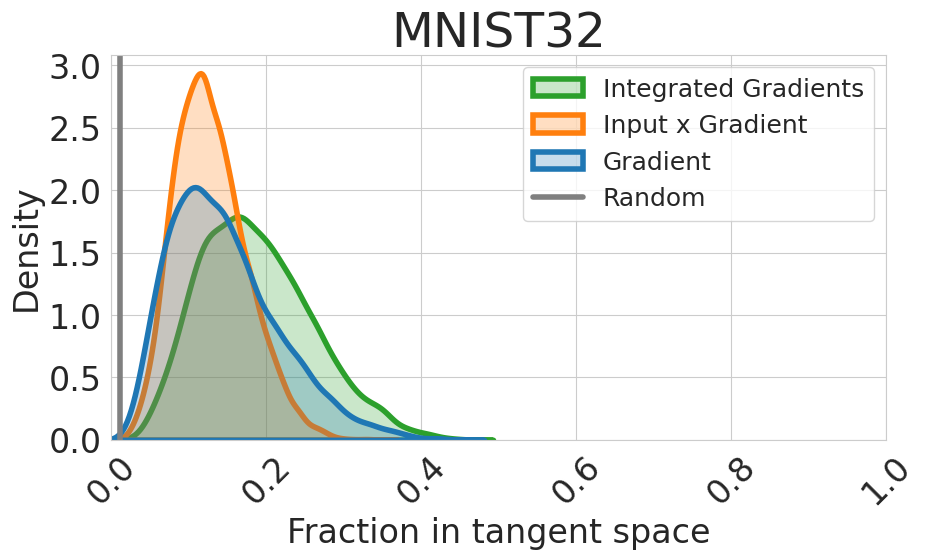

In [23]:
val_pair = []
for v in frac_grad_its:
    val_pair.append((v, 'Gradient'))
for v in frac_ixg_its:
    val_pair.append((v, 'Input x Gradient'))
for v in frac_int_grad_its:
    val_pair.append((v, 'Integrated Gradients'))
df = pd.DataFrame(data=val_pair, columns=['Value', 'Method'])
sns.set_style('whitegrid')

plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='Value', hue='Method', fill=True, legend=False, lw=4, alpha=0.25)
plt.axvline(np.sqrt(8 / 256**2), 0, 1.4, label='Random', color='gray', lw=4)
plt.legend(labels=['Integrated Gradients', 'Input x Gradient', 'Gradient', 'Random'], fontsize=18)
plt.xlim([0., 1.0])
plt.xticks(fontsize=24, rotation=45)
plt.xlabel('Fraction in tangent space', fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.title('MNIST32', fontsize=35)
plt.show()